(64, 42)
Avg # of cognates per codon:   1.15625 
Avg # of near-cognates per codon:  8.40625 
Avg # of non-cognates per codon:  32.4375

Avg # of codons tRNA is cognate to:  1.7619047619047619 
Avg # of codons tRNA is near-cogante to:  12.80952380952381 
Avg # of codons tRNA is non-cognate to:  49.42857142857143


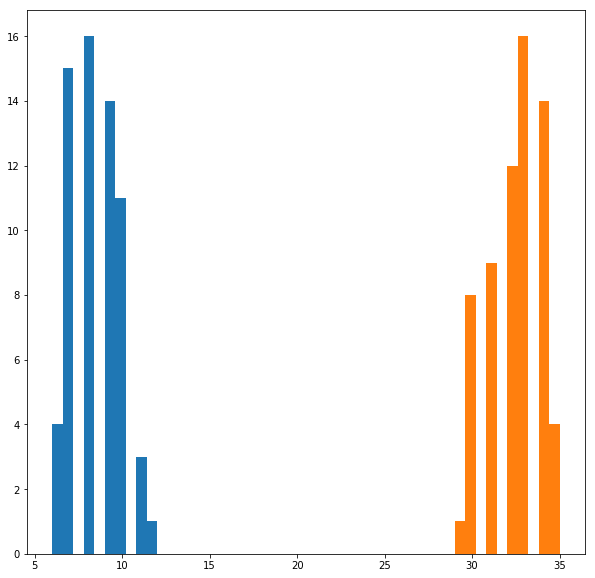

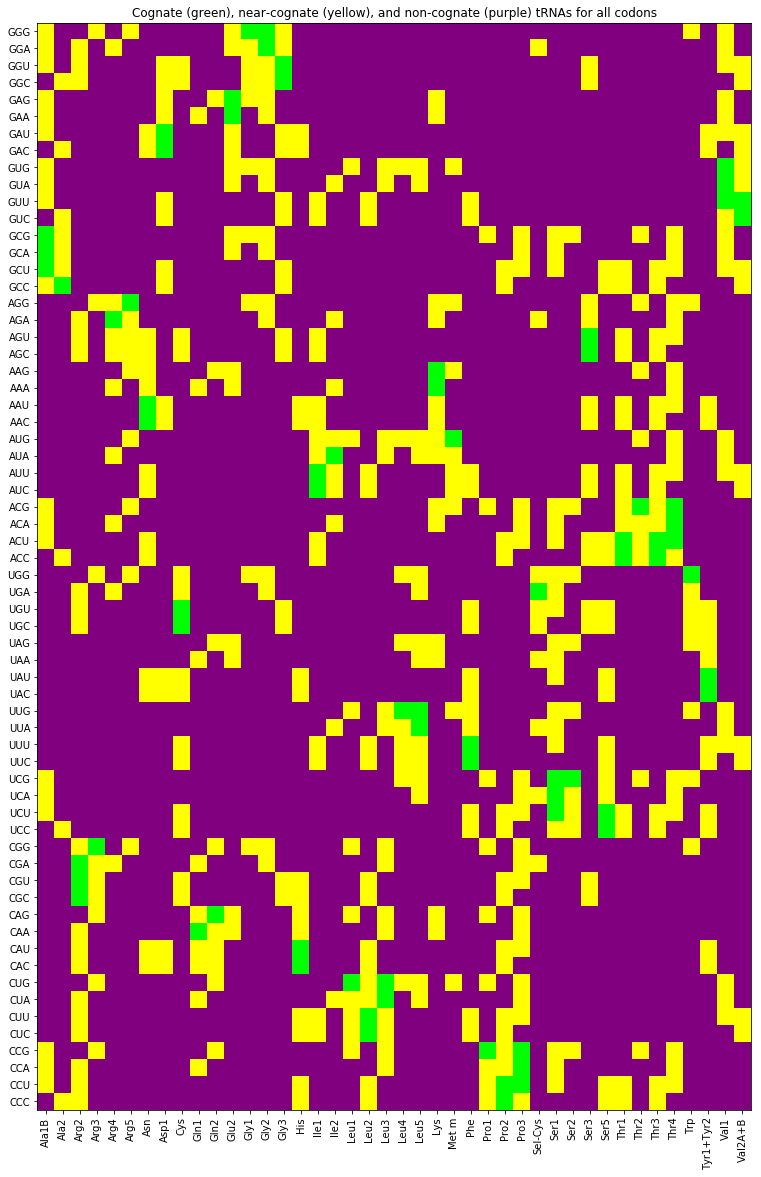

In [3]:
#Calculate the average number of cognate, near-cognate, and non-cognate tRNAs per tRNA
# The list of tRNA and their respective cognate codons are obtained from Dong et al. (1996)

from xlrd import open_workbook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import Bio
from Bio.Alphabet import generic_dna
from Bio.Seq import reverse_complement,transcribe,back_transcribe
import matplotlib.pyplot as plt
%matplotlib inline

def neighbor_count(string1,string2):
    count_diffs = 0
    for a, b in zip(string1, string2):
        if a!=b:
            count_diffs += 1
    if count_diffs==0: ##cognate
        return 1
    if count_diffs ==1: ##near-cognate
        return 0
    if count_diffs>1: ##non-cognate
        return -1
    
book = open_workbook('./tRNACodonTable.xlsx')
sheet = book.sheet_by_index(0)

# read header values into the list    
keys = [sheet.cell(row_index, 0).value for row_index in range(1,sheet.nrows)]
dict = {}
dict_maincodon={}
for row_index in range(1, sheet.nrows):
    codon_list = []
    for col_index in range(1,4):
        codon = sheet.cell(row_index,col_index).value
        if codon:
            codon_list.append(codon)
    dict[sheet.cell(row_index,0).value] = codon_list
    for col_index in range(4,5):
        anticodon = transcribe(reverse_complement(back_transcribe((sheet.cell(row_index,col_index).value))))
        dict_maincodon[sheet.cell(row_index,0).value]= anticodon

#Recreates Rodnina 2014 Fig 2
bases = ['G','A','U','C']
codonlist = [a+b+c for a in bases for b in bases for c in bases]


proximity_grid = -np.ones((len(codonlist),len(dict.keys())))
i=0
for codon in codonlist:
    j=0
    for tRNA1 in dict.keys():
        max_neighbors=-1
        for tRNA_codon in dict[tRNA1]:
            max_neighbors=neighbor_count(codon,tRNA_codon)
            if max_neighbors>proximity_grid[i,j]:
                proximity_grid[i,j] = max_neighbors
        j+=1
    i+=1
    
    
cog_grid=np.zeros((len(codonlist),3))
for i in range(len(proximity_grid)):
    cog_grid[i,0]=(proximity_grid[i]==1).sum()
    cog_grid[i,1]=(proximity_grid[i]==0).sum()
    cog_grid[i,2]=(proximity_grid[i]==-1).sum()

print(proximity_grid.shape)

tRNA_grid=np.zeros((proximity_grid.shape[1],3))
tRNA_vals = [codon[0] for codon in proximity_grid]

for i in range(len(tRNA_grid)):
    tRNA_vals = [codon[i] for codon in proximity_grid]
    tRNA_grid[i,0]=tRNA_vals.count(1)
    tRNA_grid[i,1]=tRNA_vals.count(0)
    tRNA_grid[i,2]=tRNA_vals.count(-1)


print("Avg # of cognates per codon:  ", np.average(cog_grid,axis=0)[0],
  "\nAvg # of near-cognates per codon: ", np.average(cog_grid,axis=0)[1],
  "\nAvg # of non-cognates per codon: ", np.average(cog_grid,axis=0)[2])
fig,ax = plt.subplots(figsize=(10,10))
ax.hist([codon[1] for codon in cog_grid])
ax.hist([codon[2] for codon in cog_grid])


print("\nAvg # of codons tRNA is cognate to: ", np.average(tRNA_grid,axis=0)[0],
  "\nAvg # of codons tRNA is near-cogante to: ", np.average(tRNA_grid,axis=0)[1],
  "\nAvg # of codons tRNA is non-cognate to: ", np.average(tRNA_grid,axis=0)[2])

fig, ax1 = plt.subplots(figsize=(20, 20))
ax1.imshow(proximity_grid,cmap=colors.ListedColormap(['purple','yellow','lime']))
ax1.set_title("Cognate (green), near-cognate (yellow), and non-cognate (purple) tRNAs for all codons")
ax1.set_yticks(range(0,64));
ax1.set_yticklabels(codonlist);
ax1.set_xticks(range(0,42));
plt.xticks(rotation=90)
ax1.set_xticklabels(dict.keys());

Avg # of cognates per codon:  1.15625 
Avg # of near-cognates per codon:  5.40625 
Avg # of non-cognates per codon:  35.4375


Text(0.5, 1.0, 'Cognate (green), near-cognate (yellow), and non-cognate (purple) tRNAs for all codons')

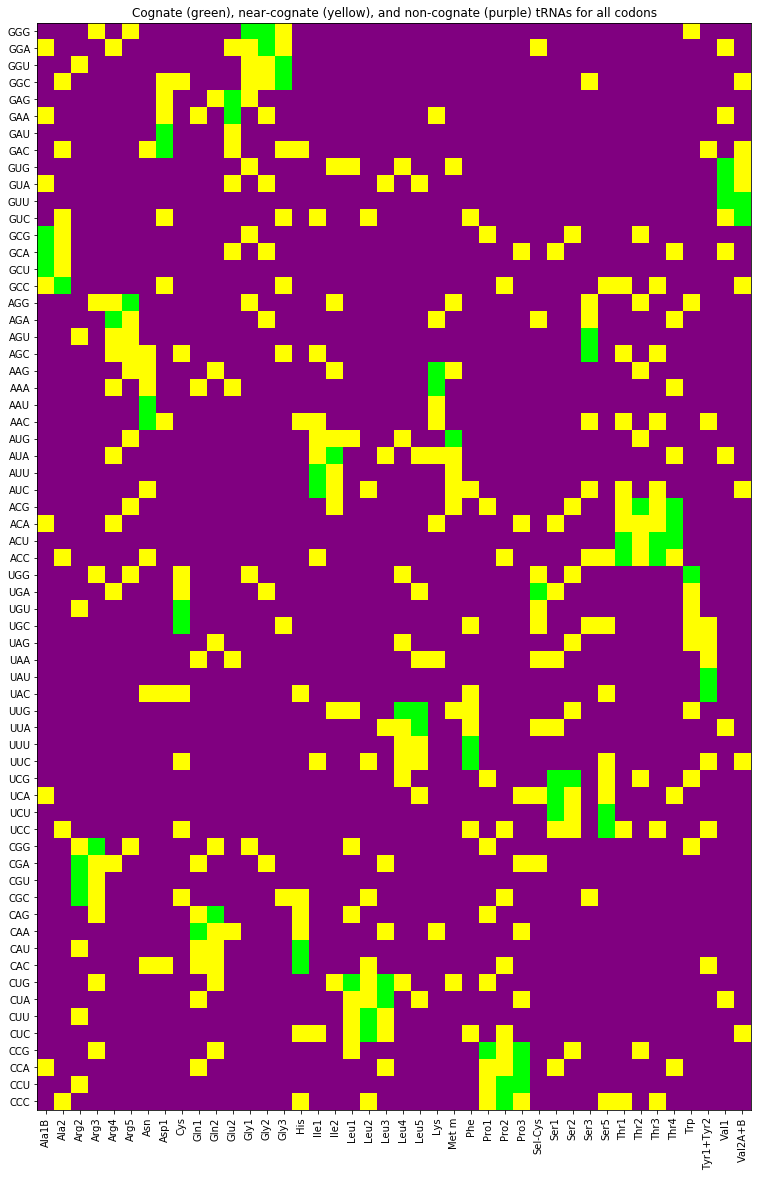

In [4]:
# To test the sensitivity of our estimation of # of cognates, near-cognates, and non-cognates, 
# we also calculate how many cognates, near-cognates, and non-cognates there would be on
# average if we considered near-cognates as only being one base pair away from 
# the tRNA anti-codon loop (not counting cognates due to wobble). This is similar to
# Fluitt et al., but we note there are discrepencies in their calculation: for
# codon GGG for example, they don't include Arg3 (recognizes CGG) as a near cognate.

bases = ['G','A','U','C']
codonlist = [a+b+c for a in bases for b in bases for c in bases]


proximity_grid = -np.ones((len(codonlist),len(dict_maincodon.keys())))
i=0
for codon in codonlist:
    j=0
    for tRNA1 in dict_maincodon.keys():
        if codon in dict[tRNA1]:
            proximity_grid[i,j]=1
        else:
            proximity_grid[i,j] = neighbor_count(codon,dict_maincodon[tRNA1])
        j+=1
    i+=1

def neighbor_count(string1,string2):
    count_diffs = 0
    for a, b in zip(string1, string2):
        if a!=b:
            count_diffs += 1
    if count_diffs==0: ##cognate
        return 1
    if count_diffs ==1: ##near-cognate
        return 0
    if count_diffs>1: ##non-cognate
        return -1
proximity_grid[24,17]=0 #Setting AUG to a near-cognate manually for Ile2, which 
#has an anticodon that appears to decode AUG, but actually has a modified cytidine
#that makes it decode AUA only. But then, AUG is still a near-cognate.
#(https://biocyc.org/META/new-image?object=ILE2-tRNAs)
#Nucleotide Sequence of E. coli B tRNAVal1, Barrell 1969 -> typo in anticodon in Dong1996.

cog_grid=np.zeros((len(codonlist),3))
for i in range(len(proximity_grid)):
    cog_grid[i,0]=(proximity_grid[i]==1).sum()
    cog_grid[i,1]=(proximity_grid[i]==0).sum()
    cog_grid[i,2]=(proximity_grid[i]==-1).sum()
np.set_printoptions(threshold=1000)
np.average(cog_grid,axis=0)

print("Avg # of cognates per codon: ", np.average(cog_grid,axis=0)[0],
  "\nAvg # of near-cognates per codon: ", np.average(cog_grid,axis=0)[1],
  "\nAvg # of non-cognates per codon: ", np.average(cog_grid,axis=0)[2])

fig, ax1 = plt.subplots(figsize=(20, 20))
ax1.imshow(proximity_grid,cmap=colors.ListedColormap(['purple','yellow','lime']))
ax1.set_yticks(range(0,64));
ax1.set_yticklabels(codonlist);
ax1.set_xticks(range(0,42));
plt.xticks(rotation=90)
ax1.set_xticklabels(dict.keys());
ax1.set_title("Cognate (green), near-cognate (yellow), and non-cognate (purple) tRNAs for all codons")
####Should be 61 not 64???? (Fluitt 61, Rodnina 64?)
###Wrote up the table wrong. Each tRNA just has ONE anticodon, not 3...so should only be comparing to that main anticodon.
#But can't just give the 3rd base complete wobble for all combinations, since only some third bases wobble to cognates.
#So need to use the table 2 from dong
#How did Dong get the list of codon recognition patterns...maybe need to check his sources.

In [5]:
#Code to make a tRNA by tRNA grid
proximity_grid = np.zeros((len(dict.keys()),len(dict.keys())))
i=0
for tRNA1 in dict.keys():
    j=0
    for tRNA2 in dict.keys():
        for codon1 in dict[tRNA1]:
            if tRNA1!=tRNA2:
                max_neighbors=0
                
                for codon2 in dict[tRNA2]:
                    max_neighbors=neighbor_count(codon1,codon2)
                    if max_neighbors>proximity_grid[i,j]:
                        proximity_grid[i,j] = max_neighbors
        j+=1
    i+=1
    
def neighbor_count(tRNA1,tRNA2):
    count_diffs = 0
    for a, b in zip(tRNA1, tRNA2):
        if a!=b:
            count_diffs += 1
    if count_diffs == 1:
        return 1
    else: return 0

In [6]:
#Should be using median time not mean like fluitt, since elongation 
#is a process happening in parallel, and because times aren't linear
#so we expect a few to be beyond k3 0.4, but most near-cognates
#to be kicked out far before that step.

In [7]:
k1 = 175
k1r = 700
k2=1500
k2r=800
#don't include k1 (transport time is what i'm including - make sure of this)
pr*t1r+pf*(t2+t2r)*(1+pf+pf**2+pf**3+pf**4+pf**5+pf**6+pf**7+pf**8+pf**9+pf**10+pf**11)

NameError: name 'pr' is not defined

In [8]:
#I need to solve the steady state probability distribution of the markov chain. 
#has rodnina 2014 already done this?

In [9]:
test=np.append(np.random.normal(1000,150,1),(np.random.normal(100,15,1)))
print(np.average(test))
print(np.std(test))

613.9861894828232
506.99910645018963


In [10]:
(pr*t1r+pf*(t2+t2r))/(1-pf)

NameError: name 'pr' is not defined

In [11]:
a = 0.3
b =0.9
c = 0
for i in range(100):
    c+=(a*b)**i
c

1.36986301369863

In [12]:
1/(1-a*b)

1.36986301369863

In [13]:
#Cognate kinetics
k1r=717
k2f=1475
k2r_cog=2
k3_cog=1529
k4=208
k5_cog=200

t1r = 1000/k1r
t2f = 1000/k2f
t2r_cog = 1000/k2r_cog
t3_cog = 1000/k3_cog
t4 = 1000/k4
t5_cog = 1000/k5_cog

#Near-cognate kinetics
k1r=717
k2f=1475
k2r_nr = 1120
k3_nr = 6
k4=209

t2r_nr = 1000/k2r_nr
t3_nr = 1000/k3_nr

#Non-cognate kinetics
k1r=700

In [14]:
np.random.seed(1)
t1r_exp=np.random.exponential(t1r,size=4000)
t2f_exp=np.random.exponential(t2f,size=4000)
t2r_cog_exp=np.random.exponential(t2r_cog,size=4000)
t3_cog_exp=np.random.exponential(t3_cog,size=4000)
t4_exp=np.random.exponential(t4,size=4000)
t5_cog_exp=np.random.exponential(t5_cog,size=4000)

t2r_nr_exp=np.random.exponential(t2r_nr,size=4000)
t3_nr_exp=np.random.exponential(t3_nr,size=4000)

print(np.average(t1r_exp))
print(np.average(t2f_exp))
print(np.average(t2r_cog_exp))
print(np.average(t3_cog_exp))
print(np.average(t4_exp))
print(np.average(t5_cog_exp))
print(np.average(t2r_nr_exp))
print(np.average(t3_nr_exp))

1.3891181621118904
0.6654345668683457
500.1896040831759
0.6569705162271943
4.840782235894922
5.010373257065323
0.8973918999216336
163.4346199589107


(array([327993.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 672007.]),
 array([ 1.39470014,  2.4369948 ,  3.47928946,  4.52158412,  5.56387878,
         6.60617344,  7.6484681 ,  8.69076277,  9.73305743, 10.77535209,
        11.81764675]),
 <a list of 10 Patch objects>)

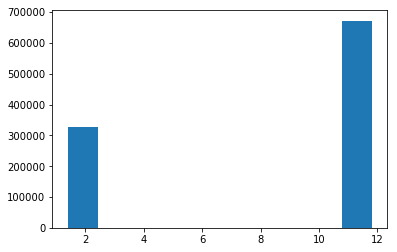

In [15]:
#Cognate kinetics
k1r=717
k2f=1475
k2r_cog=2
k3_cog=1529
k4=208
k5_cog=200

dwelltime_cog = list()


#Cognate calculation (average). Below, we plot the number of failed cognate incorporations
#due to k-1 unbinding vs. succesful cognate incorporations.
for i in range(1000000):
    dwell_t = 0
    state=1
    while state != 0 and state != 3:
        if state==1:
            if np.random.randint(0,k1r+k2f) < k1r:
                dwell_t+=t1r
                state=0
            else:
                dwell_t+=t2f
                state = 2
                
        if state==2:
            if np.random.randint(0,k2r_cog+k3_cog) < k2r_cog:
                #dwell_t+= t2r_cog
                state = 1
            else:
                dwell_t += t3_cog
                state = 3
        
        if state==3:
            dwell_t+=t4+t5_cog
            
    dwelltime_cog.append(dwell_t)
    
plt.hist(dwelltime_cog)
    
#Pick a number; if on right weighted side, do right action, if on left weighted side, left action.
#why is it proportional probability to go either direction if two pathways? Because this is what
#was found by measuring the two kinetic rates; recall, we're looking at bulk, so many
#proteins were observed to get kinetic rates, and thus probability distribution of a given
# reaction going forward.


/Users/Akshay/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


11.130834378901604
1.3884429744218185
0.672789


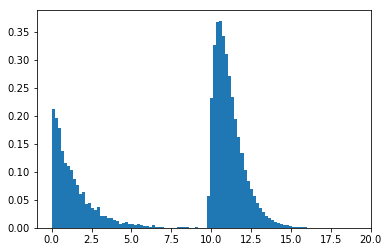

In [16]:
#Cognate calculation (distribution pulling from exponential)
dwelltime_cog_success = list()
dwelltime_cog_fail = list()

for i in range(1000000):
    dwell_t = 0
    state=1
    while state != 0 and state != 3:
        if state==1:
            if np.random.randint(0,k1r+k2f) < k1r:
                dwell_t+=np.random.choice(t1r_exp)
                dwelltime_cog_fail.append(dwell_t)
                state=0
                continue;
            else:
                dwell_t+=np.random.choice(t2f_exp)
                state = 2
                
        if state==2:
            if np.random.randint(0,k2r_cog+k3_cog) < k2r_cog:
                #dwell_t+= t2r_cog
                state = 1
            else:
                dwell_t += np.random.choice(t3_cog_exp)
                state = 3
        
        if state==3:
            dwell_t+=t4+t5_cog
            
    if state!=0: dwelltime_cog_success.append(dwell_t)


plt.hist(dwelltime_cog_success+dwelltime_cog_fail,bins=100,normed=True)
print(np.mean(dwelltime_cog_success))
print(np.mean(dwelltime_cog_fail))
print(len(dwelltime_cog_success)/(len(dwelltime_cog_success)+len(dwelltime_cog_fail)))


4.544214204438444
4.395147166867853


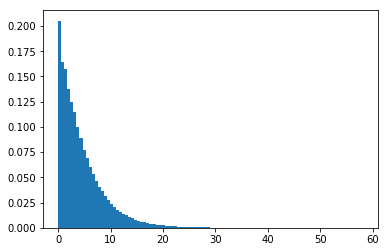

In [17]:
#Near-cognate calculation (distribution pulling from exponential)
dwelltime_nr_success = list()
dwelltime_nr_fail = list()
#Near-cognate kinetics
k1r=717
k2f=1475
k2r_nr = 1120
k3_nr = 6
k4=209

for i in range(1000000):
    dwell_t = 0
    state=1
    while state != 0 and state != 3:
        if state==1:
            if np.random.randint(0,k1r+k2f) < k1r: #should happen 32% of time (98893)
                dwell_t+=np.random.choice(t1r_exp)
                dwelltime_nr_fail.append(dwell_t)
                state=0
            else:
                dwell_t+=np.random.choice(t2f_exp)
                state = 2
                
        if state==2:
            if np.random.randint(0,k2r_nr+k3_nr) < k2r_nr: #should happen 68% of time (203117)
                dwell_t+= np.random.choice(t2r_nr_exp)
                state = 1
                #dwelltime_nr_fail.append(dwell_t)
            else:
                dwell_t += np.random.choice(t3_nr_exp) #should happen ~0.05% of times from state 2
                state = 3
                dwelltime_nr_success.append(dwell_t)
                

plt.hist(dwelltime_nr_fail,bins=100,normed=True)
print(np.mean(dwelltime_nr_fail))
print(np.std(dwelltime_nr_fail))




166.33518832511464
166.33518832511464
11011 988989 0.011011


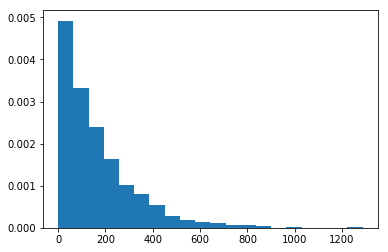

In [18]:
print(np.mean(dwelltime_nr_success))
print(np.mean(dwelltime_nr_success))
plt.hist(dwelltime_nr_success,bins=20,normed=True);
print(len(dwelltime_nr_success),len(dwelltime_nr_fail),len(dwelltime_nr_success)/(len(dwelltime_nr_success)+len(dwelltime_nr_fail)))


1.394507384454007


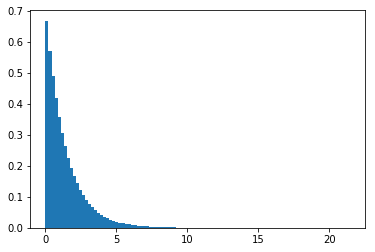

In [19]:
#Non-cognate calculation (distribution pulling from exponential)

#Non-cognate kinetics
k1r=717

t1rdist=(np.random.exponential(t1r,size=1000000))
plt.hist(t1rdist,bins=100,normed=True)
print(np.average(t1rdist))

Average cognate dwell time (successful): 11.1  ms
Average cognate dwell time (unsucessful): 1.4  ms
Proportion of succesful cognate incorporation vs. attempts:  0.67
Average near cognate dwell time (unsuccesful) 4.5  ms
Average non-cognate dwell time (unsuccesful) 1.4 ms


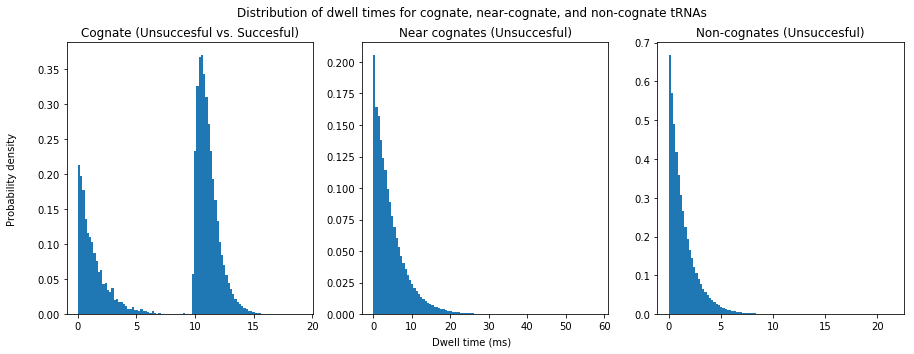

In [20]:
fig = plt.figure(figsize=(15,5))
fig.suptitle("Distribution of dwell times for cognate, near-cognate, and non-cognate tRNAs")

plt.subplot(1,3,1)
plt.hist(dwelltime_cog_success+dwelltime_cog_fail,bins=100,normed=True)
plt.title("Cognate (Unsuccesful vs. Succesful)")
plt.subplot(1,3,2)
plt.hist(dwelltime_nr_fail,bins=100,normed=True)
plt.title("Near cognates (Unsuccesful)")
#plt.subplot(1,4,3)
#plt.hist(dwelltime_nr_success,bins=100,normed=True)
#plt.title("Near cognates (Succesful)")
plt.subplot(1,3,3)
plt.hist(t1rdist,bins=100,normed=True)
plt.title("Non-cognates (Unsuccesful)")

fig.text(0.5, 0.04, 'Dwell time (ms)', ha='center')
fig.text(0.07, 0.5, 'Probability density', va='center', rotation='vertical')


print("Average cognate dwell time (successful):", round(np.average(dwelltime_cog_success),1), " ms")
print("Average cognate dwell time (unsucessful):", round(np.average(dwelltime_cog_fail),1), " ms")
print("Proportion of succesful cognate incorporation vs. attempts: ",round(len(dwelltime_cog_success)/(len(dwelltime_cog_success)+len(dwelltime_cog_fail)),2))
print("Average near cognate dwell time (unsuccesful)", round(np.average(dwelltime_nr_fail),1)," ms")
print("Average non-cognate dwell time (unsuccesful)", round(np.average(t1rdist),1), "ms")

In [20]:
r1 = [1.7]*3697719

In [21]:
moleculelist = [3697719.298,
7242955.326,
5105608.696,
3674136.905,
3162538.293,
1068328.665,
1133659.639,
1350224.215,
223450.8349,
419764.0751,
6561543.353,
789551.1111]
moleculelist = [int(x) for x in moleculelist]
radiuslist = [1.7,
2.3,
2.7,
3,
3.4,
3.5,
3.8,
4,
4.1,
4.3,
5.2,
10.4]
moleculeRadDistribution=[]
for i in range(len(moleculelist)-1):
    moleculeRadDistribution.append([radiuslist[i]]*moleculelist[i])
moleculeRadDistribution = [item for sublist in moleculeRadDistribution for item in sublist]

In [22]:
print(np.median(moleculeRadDistribution))
print(np.mean(moleculeRadDistribution))

3.0
3.23407982729


In [588]:
def calcAICc(n,k,SSE):
    k=k+1
    AIC = 2*(k)+n*np.log(SSE/n)
    AICc =  AIC + (2*(k**2)+2*k)/(n-k-1)
    return AICc

a = list()

x = rib_GrowthRate
y = activeRibosomes

for order in range(3):
    polyfit,SSE,_,_,_ = np.polyfit(x,y,order,full=True)
    a.append(calcAICc(len(x),len(polyfit),SSE)[0])
print(a)

a = list()
x = tern_GrowthRate
y = ternaryComplexes

for order in range(3):
    polyfit,SSE,_,_,_ = np.polyfit(x,y,order,full=True)
    a.append(calcAICc(len(x),len(polyfit),SSE)[0])
print(a)

a = list()
x = mass_GrowthRate
y = mass

for order in range(3):
    polyfit,SSE,_,_,_ = np.polyfit(x,y,order,full=True)
    a.append(calcAICc(len(x),len(polyfit),SSE)[0])
print(a)


a = list()
x = vol_GrowthRate
y = vol

for order in range(3):
    polyfit,SSE,_,_,_ = np.polyfit(x,y,order,full=True)
    a.append(calcAICc(len(x),len(polyfit),SSE)[0])
print(a)



[126.91551428796376, 109.6707697666493, 136.9908011002546]
[261.9873637519157, 229.46441195905336, 218.75318520059488]
[129.7198074772921, 89.95770364030888, 80.78692647532185]
[-25.69260738918682, -68.62223230876972, -66.12345934122348]


In [325]:


def LOVO(x,y,order):
    SSE_tot=0
    for i in range(0,len(y)):
        x_lovo = x[:i] + x[i+1 :]
        y_lovo = y[:i] + y[i+1 :]
        polyfit= np.polyfit(x_lovo,y_lovo,order)
        
        y_i_hat = np.polyval(polyfit,x[i])
        SSE_lovo = np.abs(y[i] - y_i_hat)
        SSE_tot += SSE_lovo
        
        x_plot = np.linspace(0.6,3)        
        y_plot   = np.polyval(polyfit,x_plot)
        #plt.plot(x_plot,y_plot)
        #print(SSE_lovo)
    SSE_avg = SSE_tot/(len(y))
    print('{:.2e}'.format(SSE_avg))

for order in range(3): 
    LOVO(rib_GrowthRate,activeRibosomes,order) #1st order
    
print("\n tern")
for order in range(3):
    LOVO(tern_GrowthRate,ternaryComplexes,order) #1st or 2nd order

print("\n")
for order in range(3):
    LOVO(mass_GrowthRate,mass,order) #1st or 2nd

print("\n")
for order in range(3):
    LOVO(vol_GrowthRate,vol,order) #1st order

2.19e+04
2.49e+03
4.07e+03

 tern
1.00e+05
2.35e+04
1.55e+04


1.78e+02
2.96e+01
2.06e+01


4.79e-01
1.51e-01
1.57e-01


In [482]:
%%latex
$.. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}$
$.. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}$


<IPython.core.display.Latex object>

[30.45013454 30.36584024 30.28297318 30.2015451  30.12156767 30.04305248
 29.96601102 29.89045469 29.81639477 29.74384245 29.67280878 29.6033047
 29.535341   29.46892834 29.40407723 29.34079803 29.27910093 29.21899594
 29.16049292 29.10360152 29.04833122 28.99469128 28.94269077 28.89233854
 28.84364323 28.79661323 28.75125672 28.70758164 28.66559567 28.62530623
 28.58672051 28.54984542 28.51468758 28.48125336 28.44954883 28.41957979
 28.39135173 28.36486984 28.34013903 28.31716388 28.29594866 28.27649735
 28.25881357 28.24290065 28.22876159 28.21639905 28.20581537 28.19701255
 28.18999226 28.18475583 28.18130425 28.17963819 28.17975796 28.18166353
 28.18535454 28.1908303  28.19808976 28.20713154 28.21795394 28.2305549
 28.24493204 28.26108266 28.27900371 28.29869183 28.32014333 28.34335422
 28.36832017 28.39503655 28.42349843 28.45370057 28.48563744 28.5193032
 28.55469174 28.59179667 28.6306113  28.67112871 28.71334167 28.75724273
 28.80282416 28.850078   28.89899604 28.94956985 29.00

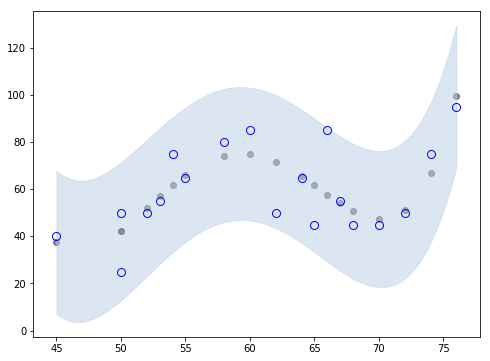

In [546]:
def plot_ci_manual(t, s_err, n, x, x2, y2, ax=None):
    """Return an axes of confidence bands using a simple approach.

    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}

    References
    ----------
    .. [1]: M. Duarte.  "Curve fitting," JUpyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb

    """
    if ax is None:
        ax = plt.gca()

    ci = t*s_err*np.sqrt(1+1/n + (x2-np.mean(x))**2/np.sum((x-np.mean(x))**2))
    print(ci)
    ax.fill_between(x2, y2+ci, y2-ci, color="#b9cfe7", edgecolor="",alpha=0.5)

    return ax
# Computations ----------------------------------------------------------------
# Raw Data
heights = np.array([50,52,53,54,58,60,62,64,66,67,68,70,72,74,76,55,50,45,65])
weights = np.array([25,50,55,75,80,85,50,65,85,55,45,45,50,75,95,65,50,40,45])

x = heights
y = weights

# Modeling with Numpy
p, cov = np.polyfit(x, y, 4, cov=True)        # parameters and covariance from of the fit
y_model = np.polyval(p, x)                    # model using the fit parameters; NOTE: parameters here are coefficients

# Statistics
n = weights.size                              # number of observations
m = p.size                                    # number of parameters
DF = n - m                                    # degrees of freedom
t = stats.t.ppf(1-0.025, n - m)                  # used for CI and PI bands

# Estimates of Error in Data/Model
resid = y - y_model                           
chi2 = np.sum((resid/y_model)**2)             # chi-squared; estimates error in data
chi2_red = chi2/(DF)                          # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2)/(DF))        # standard deviation of the error


# Plotting --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8,6))

# Data
ax.plot(x,y,"o", color="#b9cfe7", markersize=8,
         markeredgewidth=1,markeredgecolor="b",markerfacecolor="None")

# Fit
ax.scatter(x,y_model, color="0.1", alpha=0.5, label="Fit")  

x2 = np.linspace(np.min(x), np.max(x), 100)
#y2 = np.linspace(np.min(y_model), np.max(y_model), 100)
y2 = np.polyval(p,x2)

# Confidence Interval (select one)
plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
#plot_ci_bootstrap(n, x, y, resid, ax=ax)

plt.show()


[ 4023.79032258 13669.91935484 25727.58064516 37785.24193548
 49842.90322581 61900.56451613  4023.79032258 13669.91935484
 25727.58064516 37785.24193548 49842.90322581 61900.56451613]
4859294166.666667
51824225.80645172
0.9893350301445114
[1970.82442588 1965.47033251 1960.21449441 1955.057704   1950.00074708
 1945.04440233 1940.1894408  1935.43662545 1930.78671061 1926.24044147
 1921.79855359 1917.4617724  1913.23081263 1909.10637784 1905.08915992
 1901.1798385  1897.37908051 1893.68753964 1890.10585581 1886.6346547
 1883.27454723 1880.02612905 1876.88998009 1873.86666404 1870.95672787
 1868.16070142 1865.47909687 1862.91240833 1860.46111144 1858.12566287
 1855.90649996 1853.80404033 1851.81868148 1849.95080041 1848.20075333
 1846.56887525 1845.05547971 1843.6608585  1842.38528134 1841.22899564
 1840.19222628 1839.27517536 1838.47802203 1837.80092231 1837.24400893
 1836.80739122 1836.49115498 1836.29536239 1836.22005199 1836.2652386
 1836.43091333 1836.71704357 1837.12357303 1837.65042

Text(0, 0.5, '# of active ribosomes')

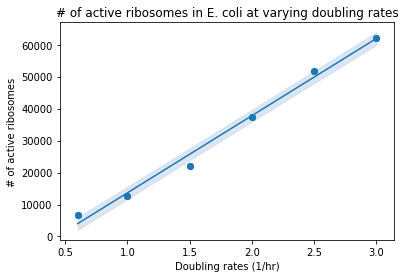

In [551]:
# Calculation of fit curves for data; Plot all 4 relevant curves on same plot; can imagine making a figure showing how I 
# I sweep with some error for each region with shaded bars outlining.
#Can try single, double, triple polynomials w/ holdout crossvalidation to see which is best fit that doesn't overfit

#Active Ribosomes
x = np.array([0.6,1.0,1.5,2.0,2.5,3.0]*2)
y = np.array([8000,15000,26000,44000,61000,73000]*2)
y = np.array([int(x*0.85) for x in y])

polyfit = np.polyfit(x, y, 1)        # parameters and covariance from of the fit

# Statistics
n = x.size                              # number of observations
m = polyfit.size                                    # number of parameters
DF = n - m                                    # degrees of freedom
t = stats.t.ppf(1-0.025, DF)                  # used for CI and PI bands

# Estimates of Error in Data/Model
y_hat = np.polyval(polyfit,x)
print(y_hat)
SSE = np.sum((y-y_hat)**2) # Sum of squared errors
var_hat = SSE/(DF)
squared_dist_from_mean = np.sum((x-np.average(x))**2)
SE_b_hat = np.sqrt(var_hat/squared_dist_from_mean)

#resid = y - y_hat                           
#chi2 = np.sum((resid/y_hat)**2)             # chi-squared; estimates error in data
#chi2_red = chi2/(DF)                          # reduced chi-squared; measures goodness of fit
#s_err = np.sqrt(np.sum(resid**2)/(DF))        # standard deviation of the error
SS_tot = np.sum((y-np.average(y))**2)
print(SS_tot)
print(SSE)
print(1-SSE/SS_tot)

#####PLOTTING####
fig,ax=plt.subplots()

x_sweep = np.linspace(np.min(x), np.max(x), 100)
y_hat_sweep = np.polyval(polyfit,x_sweep)

plot_ci_manual(t, SE_b_hat, n, x, x_sweep, y_hat_sweep, ax=ax)

plt.scatter(x,y)
plt.plot(x_sweep,y_hat_sweep)
plt.title("# of active ribosomes in E. coli at varying doubling rates")
plt.xlabel("Doubling rates (1/hr)")
plt.ylabel("# of active ribosomes")


                            OLS Regression Results                            
Dep. Variable:                    rib   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     927.6
Date:                Wed, 17 Oct 2018   Prob (F-statistic):           3.41e-11
Time:                        10:36:16   Log-Likelihood:                -108.70
No. Observations:                  12   AIC:                             221.4
Df Residuals:                      10   BIC:                             222.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.045e+04   1545.481     -6.759      0.0

/Users/Akshay/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


array([ -460.,  8500., 19700., 30900., 42100., 53300.,  -460.,  8500.,
       19700., 30900., 42100., 53300.])

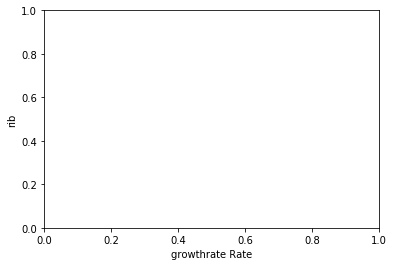

In [545]:
# Calculation of fit curves for data; Plot all 4 relevant curves on same plot; can imagine making a figure showing how I 
# I sweep with some error for each region with shaded bars outlining.
#Can try single, double, triple polynomials w/ holdout crossvalidation to see which is best fit that doesn't overfit
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn
import pandas as pd

#Active Ribosomes
x = np.array([0.6,1.0,1.5,2.0,2.5,3.0]*2)
y = np.array([8000,15000,26000,44000,61000,73000]*2)
y = np.array([int(x*0.85) for x in y])
df = pd.DataFrame(
    {'growthrate': x,
     'rib': y,
    })
#scat1 = seaborn.regplot(x="growthrate", y="rib", scatter=True, data=df,x_ci="sd")

plt.xlabel('growthrate Rate')
plt.ylabel('rib')

reg1 = smf.ols('rib ~ growthrate',data=df).fit()
print(reg1.summary())

reg2 = smf.ols('rib ~ growthrate + I(growthrate**2)',data=df).fit()
#print(reg2.summary())

model = sm.OLS(y,x)
results = model.fit()
print(results.params)
res = mod.fit()
print(res.conf_int(0.025))

def y(x):
    #return -1.72e4+2.06e4*x
    #return -1.045e4 + 2.412e4*x
    return -1.39e4+2.24e4*x
y(x)

[ 24115.32258065 -10445.40322581]
[ 24115.32258065 -10445.40322581]


Text(0, 0.5, '# of active ribosomes')

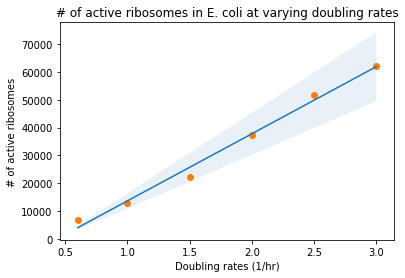

In [471]:
# Calculation of fit curves for data; Plot all 4 relevant curves on same plot; can imagine making a figure showing how I 
# I sweep with some error for each region with shaded bars outlining.
#Can try single, double, triple polynomials w/ holdout crossvalidation to see which is best fit that doesn't overfit

#Active Ribosomes
rib_GrowthRate = [0.6,1.0,1.5,2.0,2.5,3.0]
ribosomes = [8000,15000,26000,44000,61000,73000]
activeRibosomes = [int(x*0.85) for x in ribosomes]
ribPolyFit,SSE,_,_,_ = np.polyfit(rib_GrowthRate,activeRibosomes,1,full=True)
x_rib = np.linspace(0.6,3)
y_rib = np.polyval(ribPolyFit,x_rib)

err_rib = [y_rib_i*0.2 for y_rib_i in y_rib]
plt.fill_between(x_rib,y_rib-err_rib,y_rib+err_rib,alpha=0.1)
print(ribPolyFit)

plt.scatter(rib_GrowthRate,activeRibosomes)
plt.plot(x_rib,y_rib)
plt.title("# of active ribosomes in E. coli at varying doubling rates")
plt.xlabel("Doubling rates (1/hr)")
plt.ylabel("# of active ribosomes")


0.9636214090581514


Text(0, 0.5, '# of ternary complexes')

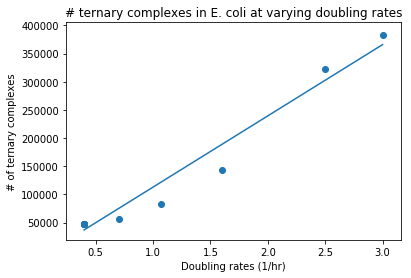

In [569]:
#Ternary complexes
fig,ax = plt.subplots()
np.random.seed(0)
tern_GrowthRate = [0.4,0.7,1.07,1.6,2.5,3.0]+[0.4]*5
ternaryComplexes = [48000,57000,83000,143000,323000,383000]+[48000]*5

##Statistics
tern_PolyFit,SSE,_,_,_ = np.polyfit(tern_GrowthRate,ternaryComplexes,1,full=True)
y_hat = np.polyval(tern_PolyFit,tern_GrowthRate)
SSE = np.sum((ternaryComplexes-y_hat)**2) # Sum of squared errors
SS_tot = np.sum((ternaryComplexes-np.average(ternaryComplexes))**2)
print(1-SSE/SS_tot)

x_tern = np.linspace(0.4,3)
y_tern = np.polyval(tern_PolyFit,x_tern)
ax.plot(x_tern,y_tern)
ax.scatter(tern_GrowthRate,ternaryComplexes)
ax.set_title("# ternary complexes in E. coli at varying doubling rates")
ax.set_xlabel("Doubling rates (1/hr)")
ax.set_ylabel("# of ternary complexes")

0.9915716375786843
0.9884110016706908


Text(0, 0.5, 'Cell mass (fg)')

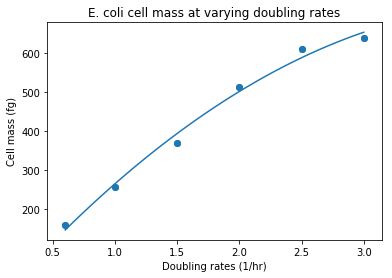

In [587]:
#Cell mass
mass_GrowthRate = [0.6,1.0,1.5,2.0,2.5,3.0]*2
mass = [159,258,371,515,611,640]*2
mass_PolyFit = np.polyfit(mass_GrowthRate,mass,2)
x_mass = np.linspace(0.6,3)
y_mass = np.polyval(mass_PolyFit,x_mass)
#y_mass = x_mass*mass_PolyFit[0]+mass_PolyFit[1]

n=len(mass_GrowthRate)
p=len(mass_PolyFit)
##Statistics
y_hat = np.polyval(mass_PolyFit,mass_GrowthRate)
SSE = np.sum((mass-y_hat)**2) # Sum of squared errors
SS_tot = np.sum((mass-np.average(mass))**2)
R2 = 1-SSE/SS_tot
print(R2)
R2_adj = 1-(1-R2)*(n-1)/(n-p-1)
print(R2_adj)


plt.plot(x_mass,y_mass)
plt.scatter(mass_GrowthRate,mass)
plt.title("E. coli cell mass at varying doubling rates")
plt.xlabel("Doubling rates (1/hr)")
plt.ylabel("Cell mass (fg)")

0.8743372571628939


(0, 3)

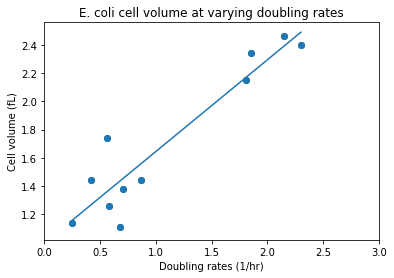

In [580]:
## Cell Volume
vol_GrowthRate = [0.25,0.42,0.56,0.58,0.68,0.71,0.87,1.81,1.85,2.15,2.3]*2
vol = [1.14,1.44,1.74,1.26,1.11,1.38,1.44,2.15,2.34,2.46,2.4]*2
vol_PolyFit = np.polyfit(vol_GrowthRate,vol,1)


##Statistics
y_hat = np.polyval(vol_PolyFit,vol_GrowthRate)
SSE = np.sum((vol-y_hat)**2) # Sum of squared errors
SS_tot = np.sum((vol-np.average(vol))**2)
print(1-SSE/SS_tot)

x_vol = np.linspace(0.25,2.3)
y_vol = np.polyval(vol_PolyFit,x_vol)
plt.plot(x_vol,y_vol)
plt.scatter(vol_GrowthRate,vol)
plt.title("E. coli cell volume at varying doubling rates")
plt.xlabel("Doubling rates (1/hr)")
plt.ylabel("Cell volume (fL)")
plt.xlim(0,3)

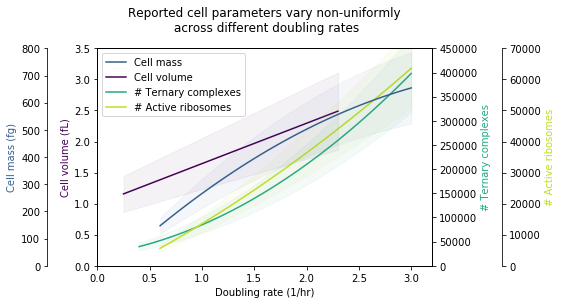

In [28]:
fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()
par2 = host.twinx()
par3 = host.twinx()

host.set_xlim(0, 3.2)
host.set_ylim(0, 3.5)
par1.set_ylim(0, 450000)
par2.set_ylim(0, 70000)
par3.set_ylim(0, 800)

host.set_xlabel("Doubling rate (1/hr)")
host.set_ylabel("Cell volume (fL)")
par1.set_ylabel("# Ternary complexes")
par2.set_ylabel("# Active ribosomes")
par3.set_ylabel("Cell mass (fg)")

color1 = plt.cm.viridis(0)
color2 = plt.cm.viridis(0.6)
color3 = plt.cm.viridis(.9)
color4 = plt.cm.viridis(0.3)

p1, = host.plot(x_vol, y_vol, color=color1,label="Cell volume")
host.fill_between(x_vol,y_vol-err_vol,y_vol+err_vol,alpha=0.05,color=color1)

p2, = par1.plot(x_tern, y_tern, color=color2, label="# Ternary complexes")
par1.fill_between(x_tern,y_tern-err_tern,y_tern+err_tern,alpha=0.05,color=color2)

p3, = par2.plot(x_rib, y_rib, color=color3, label="# Active ribosomes")
par2.fill_between(x_rib,y_rib-err_rib,y_rib+err_rib,alpha=0.05,color=color3)

p4, = par3.plot(x_mass, y_mass, color=color4, label="Cell mass")
par3.fill_between(x_mass,y_mass-err_mass,y_mass+err_mass,alpha=0.05,color=color4)


lns = [p4,p1, p2, p3]
host.legend(handles=lns, loc='best')

# right, left, top, bottom
par2.spines['right'].set_position(('outward', 70))

par3.spines['left'].set_position(('outward', 50)) 
par3.spines["left"].set_visible(True) 
par3.yaxis.set_label_position('left') 
par3.yaxis.set_ticks_position('left')# no x-ticks                 
#par3.xaxis.set_ticks([])
# no x-ticks                 
#par2.xaxis.set_ticks([])
# Sometimes handy, same for xaxis
#par2.yaxis.set_ticks_position('right')
#host.tick_params(axis='x', **tkw)


host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())
par3.yaxis.label.set_color(p4.get_color())

plt.title("Reported cell parameters vary non-uniformly\n across different doubling rates",y=1.05)

#Note this graph doesn't account for doubling of # ribosomes; that would be confusing
#Could make a second graph with # tern and # rib for a voxel

In [590]:
from analysis_parameters import *
%load_ext autoreload
%autoreload


In [591]:

#First calculate how, on average, volume fraction of ribosomes, crowders, ternary complexes changes w/ growth rate
dbl_rate=np.linspace(0.6,3,10)

vox_len = [[],[],[]]
rib_volfrac=[[],[],[]]
tern_volfrac = [[],[],[]]
crowder_volfrac = [[],[],[]]
total_volfrac =[[],[],[]]
rib_num=[[],[],[]]
tern_num=[[],[],[]]
crowder_num=[[],[],[]]
cell_vol_frac_tot = [[],[],[]]

###Calculate the standard deviation by averaging across different permutations####
for i in range(len(dbl_rate)):
    vox_len_i = list()
    rib_volfrac_i=list()
    tern_volfrac_i = list()
    crowder_volfrac_i = list()
    total_volfrac_i =list()
    rib_num_i=list()
    tern_num_i=list()
    crowder_num_i=list()
    
    cell_volfrac_tot_i = list()
    
    ## Creates a list of error (e.g., -20% to 20% for each parameter)
    err_rib=np.concatenate((np.linspace(-0.2,0,5),np.linspace(0,0.2,5)[1:]))
    err_tern=np.concatenate((np.linspace(-0.2,0,5),np.linspace(0,0.2,5)[1:]))
    err_mass=np.concatenate((np.linspace(-0.2,0,5),np.linspace(0,0.2,5)[1:]))
    err_vol = np.concatenate((np.linspace(-0.2,0,5),np.linspace(0,0.2,5)[1:]))
    nuc_volfrac = np.linspace(0,0.5,5)
    
    ## Depth first scan of entire parameter space w/ error in all combinations
    ## Calculates voxel parameters for each set of paramters in the parameter space
    ## Ignores voxel paramters that calculate over volume fraction 0.8., since above this
    ## we expect to be unphysical and thus the input parameters likely do not exist in combination in cells
    ## appends each calculated voxel param to corresponding list (each list describes then, how that param
    ## varies across error state space)
    for err_i in range(len(err_rib)):
        for err_j in range(len(err_tern)):
            for err_k in range(len(err_mass)):
                for err_l in range(len(err_vol)):
                    for m in range(len(nuc_volfrac)):
                        cellParams, voxelParams = calcParams(f_rib(dbl_rate[i])*(1+err_rib[err_i]),
                                                                   f_tern(dbl_rate[i])*(1+err_tern[err_j]),
                                                                   f_mass(dbl_rate[i])*(1+err_mass[err_k]),
                                                                   f_vol(dbl_rate[i])*(1+err_vol[err_l]),
                                                                   nuc_volfrac[m])

                        if(voxelParams[1][3]<0.8): ###A hard cap on max total volume fraction; set because Qi & Tanner 2011 show that ~0.8 is max for bidisperse system with lambda~5. Thus other parameter combinations must be invalid
                            vox_len_i.append(voxelParams[0])
                            rib_volfrac_i.append(voxelParams[1][0])
                            tern_volfrac_i.append(voxelParams[1][1])
                            crowder_volfrac_i.append(voxelParams[1][2])
                            total_volfrac_i.append(voxelParams[1][3])

                            rib_num_i.append(voxelParams[2][0])
                            tern_num_i.append(voxelParams[2][1])
                            crowder_num_i.append(voxelParams[2][2])
                            
                            cell_volfrac_tot_i.append(cellParams[1][3])
    
    ## Average across possible parameter outputs for a given growth rate (variability comes from error state space)
    ## Calculate percentiles 5th and 95th of parameter outputs (from error state space) to capture variability 
    
    vox_len[0].append(np.average(vox_len_i))
    vox_len[1].append(np.percentile(vox_len_i,5))
    vox_len[2].append(np.percentile(vox_len_i,95))

    rib_volfrac[0].append(np.average(rib_volfrac_i))
    rib_volfrac[1].append(np.percentile(rib_volfrac_i,5))
    rib_volfrac[2].append(np.percentile(rib_volfrac_i,95))
    
    tern_volfrac[0].append(np.average(tern_volfrac_i))
    tern_volfrac[1].append(np.percentile(tern_volfrac_i,5))
    tern_volfrac[2].append(np.percentile(tern_volfrac_i,95))
    
    crowder_volfrac[0].append(np.average(crowder_volfrac_i))
    crowder_volfrac[1].append(np.percentile(crowder_volfrac_i,5))
    crowder_volfrac[2].append(np.percentile(crowder_volfrac_i,95))
    
    total_volfrac[0].append(np.average(total_volfrac_i))
    total_volfrac[1].append(np.percentile(total_volfrac_i,5))
    total_volfrac[2].append(np.percentile(total_volfrac_i,95))
    
    rib_num[0].append(np.average(rib_num_i))
    rib_num[1].append(np.percentile(rib_num_i,5))
    rib_num[2].append(np.percentile(rib_num_i,95))
    
    tern_num[0].append(np.average(tern_num_i))
    tern_num[1].append(np.percentile(tern_num_i,5))
    tern_num[2].append(np.percentile(tern_num_i,95))

    crowder_num[0].append(np.average(crowder_num_i))
    crowder_num[1].append(np.percentile(crowder_num_i,5))
    crowder_num[2].append(np.percentile(crowder_num_i,95))
    
    cell_vol_frac_tot[0].append(np.average(cell_volfrac_tot_i))
    cell_vol_frac_tot[1].append(np.percentile(cell_volfrac_tot_i,5))
    cell_vol_frac_tot[2].append(np.percentile(cell_volfrac_tot_i,95))


    #print(crowder_num_i[np.argmax(total_volfrac_i)],
     #     rib_num_i[np.argmax(total_volfrac_i)],
      #    tern_num_i[np.argmax(total_volfrac_i)],
       #     vox_len_i[np.argmax(total_volfrac_i)],
        #    rib_volfrac_i[np.argmax(total_volfrac_i)],
         #   crowder_volfrac_i[np.argmax(total_volfrac_i)])
    #print(np.min(total_volfrac_i),np.max(total_volfrac_i))
    #print(np.percentile(total_volfrac_i,[5,95]))
    print(np.average(total_volfrac_i),np.std(total_volfrac_i), "   ", np.average(cell_volfrac_tot_i),np.std(cell_volfrac_tot_i))
    #print(vox_len_i)

0.15008161588817548 0.027127060357733386     0.133992952088965 0.020952920700095502
0.21633561911722873 0.04095120512481815     0.1891586176129324 0.029480691089485766
0.2709941268877422 0.052913471670538954     0.23401985838638076 0.03633550764780279
0.31720582232713623 0.06325852523487215     0.2713895665352421 0.041973759129307335
0.35645193514392115 0.0721118600888908     0.3031422100522611 0.04670916385170254
0.3913537330163827 0.08037116223670422     0.33057504706511626 0.050761030572666996
0.4218967133225685 0.08731338496354135     0.3546144217199132 0.054286605155767054
0.4488842239180779 0.09380034097255394     0.37591399531608005 0.05736847945087668
0.4735440963104718 0.09922343366178614     0.39468620969316814 0.05979791554491884
0.4942504874736664 0.10245039857524958     0.4112977231634074 0.06177889524579085


Text(0.09, 0.5, 'Number of molecules')

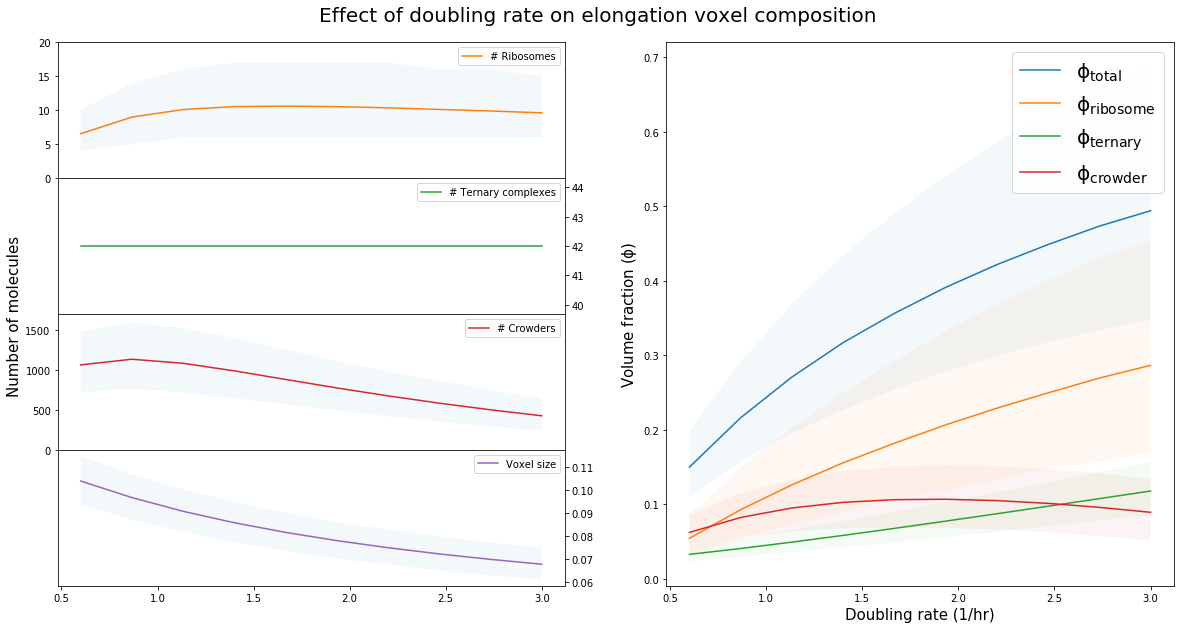

In [592]:
fig,ax = plt.subplots(4,2,sharex=True,figsize=(20,10))
ax1 = plt.subplot2grid((1, 2), (0, 1), rowspan=1)

ax1.plot(dbl_rate,total_volfrac[0],label=r'$\mathregular{\phi_{ total}}$')
ax1.fill_between(dbl_rate,total_volfrac[1],total_volfrac[2],alpha=0.05)

ax1.plot(dbl_rate,rib_volfrac[0],label=r'$\mathregular{\phi_{ ribosome}}$')
ax1.fill_between(dbl_rate,rib_volfrac[1],rib_volfrac[2],alpha=0.05)

ax1.plot(dbl_rate,tern_volfrac[0],label=r'$\mathregular{\phi_{ ternary}}$')
ax1.fill_between(dbl_rate,tern_volfrac[1],tern_volfrac[2],alpha=0.05)

ax1.plot(dbl_rate,crowder_volfrac[0],label=r'$\mathregular{\phi_{ crowder}}$')
ax1.fill_between(dbl_rate,crowder_volfrac[1],crowder_volfrac[2],alpha=0.05)

ax1.legend(prop={'size':20})
ax1.set_xlabel("Doubling rate (1/hr)",fontsize=15)
ax1.set_ylabel("Volume fraction ($\mathregular{\phi}$)",fontsize=15)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

ax[0][0].plot(dbl_rate,rib_num[0],label='# Ribosomes',color=colors[1])
ax[0][0].fill_between(dbl_rate,rib_num[1],rib_num[2],alpha=0.05)
ax[0][0].set_ylim(0,20)

ax[1][0].plot(dbl_rate,tern_num[0],label='# Ternary complexes',color=colors[2])
ax[1][0].fill_between(dbl_rate,tern_num[1],tern_num[2],alpha=0.05)
ax[1][0].yaxis.tick_right()

ax[2][0].plot(dbl_rate,crowder_num[0],label='# Crowders',color=colors[3])
ax[2][0].fill_between(dbl_rate,crowder_num[1],crowder_num[2],alpha=0.05)
ax[2][0].set_ylim(0,1700)

ax[3][0].plot(dbl_rate,vox_len[0],label='Voxel size',color=colors[4])
ax[3][0].fill_between(dbl_rate,vox_len[1],vox_len[2],alpha=0.05)
ax[3][0].yaxis.tick_right()

ax[0][0].legend(prop={'size':10})
ax[1][0].legend(prop={'size':10})
ax[2][0].legend(prop={'size':10})
ax[3][0].legend(prop={'size':10})

fig.subplots_adjust(hspace=0)

ax[3][1].set_xlabel("Doubling rate (1/hr)",fontsize=15)
fig.suptitle("Effect of doubling rate on elongation voxel composition",y=0.93,fontsize=20)
fig.text(0.09, 0.5, 'Number of molecules', va='center', rotation='vertical',fontsize=15)


In [107]:
print(f_tern(1.5))


139482.239447


In [133]:
##Sanity check

cell_mass = f_mass(0.6)
cell_vol = f_vol(0.6)
rib_num = f_rib(0.6)
tern_num = f_tern(0.6)
rib = Macromolecule(rib_mass, rib_rad,rib_num)
tern= Macromolecule(tern_mass,tern_rad, tern_num)
crowder = Macromolecule(crowder_mass,crowder_rad)
lowCell = Cell(cell_mass,cell_vol,rib,tern,crowder, nucleoid_volfrac)
vox = Voxel(42, lowCell)
vox.printProperties()

cell_mass = f_mass(1.0)
cell_vol = f_vol(1.0)
rib_num = f_rib(1.0)
tern_num = f_tern(1.0)
rib = Macromolecule(rib_mass, rib_rad,rib_num)
tern= Macromolecule(tern_mass,tern_rad, tern_num)
crowder = Macromolecule(crowder_mass,crowder_rad)
lowCell = Cell(cell_mass,cell_vol,rib,tern,crowder, nucleoid_volfrac)
vox = Voxel(42, lowCell)
vox.printProperties()

cell_mass = f_mass(1.5)
cell_vol = f_vol(1.5)
rib_num = f_rib(1.5)
tern_num = f_tern(1.5)
rib = Macromolecule(rib_mass, rib_rad,rib_num)
tern= Macromolecule(tern_mass,tern_rad, tern_num)
crowder = Macromolecule(crowder_mass,crowder_rad)
lowCell = Cell(cell_mass,cell_vol,rib,tern,crowder, nucleoid_volfrac)
vox = Voxel(42, lowCell)
vox.printProperties()

cell_mass = f_mass(2.0)
cell_vol = f_vol(2.0)
rib_num = f_rib(2.0)
tern_num = f_tern(2.0)
rib = Macromolecule(rib_mass, rib_rad,rib_num)
tern= Macromolecule(tern_mass,tern_rad, tern_num)
crowder = Macromolecule(crowder_mass,crowder_rad)
lowCell = Cell(cell_mass,cell_vol,rib,tern,crowder, nucleoid_volfrac)
vox = Voxel(42, lowCell)
vox.printProperties()

cell_mass = f_mass(2.5)
cell_vol = f_vol(2.5)
rib_num = f_rib(2.5)
tern_num = f_tern(2.5)
rib = Macromolecule(rib_mass, rib_rad,rib_num)
tern= Macromolecule(tern_mass,tern_rad, tern_num)
crowder = Macromolecule(crowder_mass,crowder_rad)
lowCell = Cell(cell_mass,cell_vol,rib,tern,crowder, nucleoid_volfrac)
vox = Voxel(42, lowCell)
vox.printProperties()

cell_mass = f_mass(3.0)
cell_vol = f_vol(3.0)
rib_num = f_rib(3.0)
tern_num = f_tern(3.0)
rib = Macromolecule(rib_mass, rib_rad,rib_num)
tern= Macromolecule(tern_mass,tern_rad, tern_num)
crowder = Macromolecule(crowder_mass,crowder_rad)
highCell = Cell(cell_mass,cell_vol,rib,tern,crowder, nucleoid_volfrac)
vox = Voxel(42, highCell)
vox.printProperties()
print(f_tern(0.6))



 Volume:  0.00111359039279 
 Voxel length:  0.103651396683 
 Rib vol frac:  0.0752379888715 
 Tern vol frac: 0.0324465450309 
 Crowder vol frac:  0.0614185345934 
 Total vol frac: 0.169103068496 
 Voxel num tern:  42 
 Voxel num rib:  9.0 
 Voxel num crowder:  1045.0

 Volume:  0.000815350109981 
 Voxel length:  0.0934217599733 
 Rib vol frac:  0.148429205402 
 Tern vol frac: 0.0443149027435 
 Crowder vol frac:  0.0881387407338 
 Total vol frac: 0.28088284888 
 Voxel num tern:  42 
 Voxel num rib:  13.0 
 Voxel num crowder:  1098.0

 Volume:  0.000593135025591 
 Voxel length:  0.0840203571972 
 Rib vol frac:  0.235427847976 
 Tern vol frac: 0.0609172604327 
 Crowder vol frac:  0.102842109681 
 Total vol frac: 0.399187218089 
 Voxel num tern:  42 
 Voxel num rib:  15.0 
 Voxel num crowder:  932.0

 Volume:  0.000459087093269 
 Voxel length:  0.077143326307 
 Rib vol frac:  0.304169959646 
 Tern vol frac: 0.0787043708165 
 Crowder vol frac:  0.104927993101 
 Total vol frac: 0.4878023235

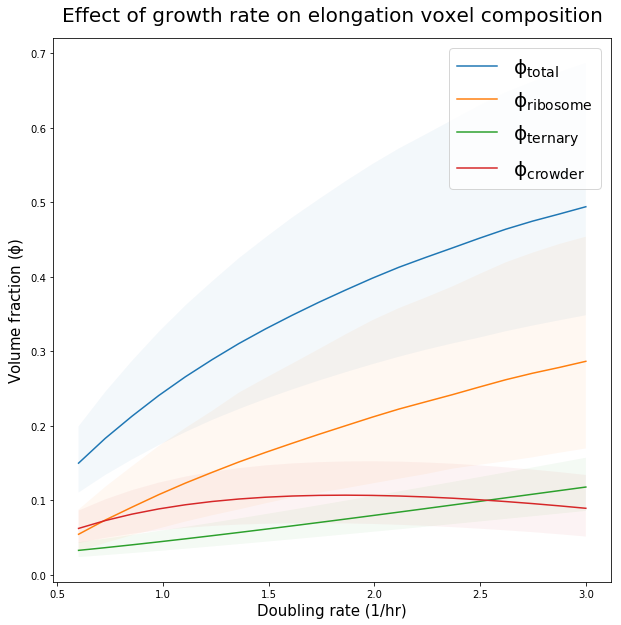

In [50]:
#calculate a few more growth rate data points; refine the variance for inputs to this graph (mass, vol,etc.)
fig,ax = plt.subplots(figsize=(10,10))

ax.plot(dbl_rate,total_volfrac[0],label=r'$\mathregular{\phi_{ total}}$')
ax.fill_between(dbl_rate,total_volfrac[1],total_volfrac[2],alpha=0.05)

ax.plot(dbl_rate,rib_volfrac[0],label=r'$\mathregular{\phi_{ ribosome}}$')
ax.fill_between(dbl_rate,rib_volfrac[1],rib_volfrac[2],alpha=0.05)

ax.plot(dbl_rate,tern_volfrac[0],label=r'$\mathregular{\phi_{ ternary}}$')
ax.fill_between(dbl_rate,tern_volfrac[1],tern_volfrac[2],alpha=0.05)

ax.plot(dbl_rate,crowder_volfrac[0],label=r'$\mathregular{\phi_{ crowder}}$')
ax.fill_between(dbl_rate,crowder_volfrac[1],crowder_volfrac[2],alpha=0.05)

ax.legend(prop={'size':20})
ax.set_xlabel("Doubling rate (1/hr)",fontsize=15)
ax.set_ylabel("Volume fraction ($\mathregular{\phi}$)",fontsize=15)
ax.set_title("Effect of growth rate on elongation voxel composition",fontsize=20,y=1.02)

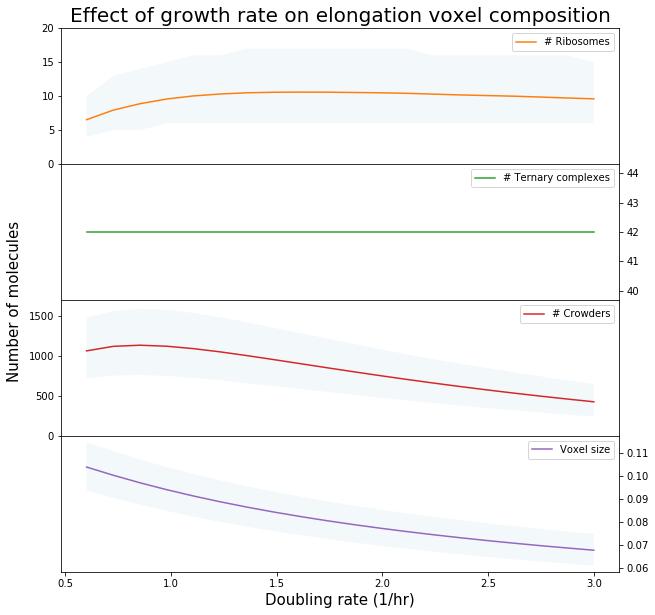

In [53]:
fig,ax = plt.subplots(4,1,sharex=True,figsize=(10,10))
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

ax[0].plot(dbl_rate,rib_num[0],label='# Ribosomes',color=colors[1])
ax[0].fill_between(dbl_rate,rib_num[1],rib_num[2],alpha=0.05)
ax[0].set_ylim(0,20)

ax[1].plot(dbl_rate,tern_num[0],label='# Ternary complexes',color=colors[2])
ax[1].fill_between(dbl_rate,tern_num[1],tern_num[2],alpha=0.05)
ax[1].yaxis.tick_right()

ax[2].plot(dbl_rate,crowder_num[0],label='# Crowders',color=colors[3])
ax[2].fill_between(dbl_rate,crowder_num[1],crowder_num[2],alpha=0.05)
ax[2].set_ylim(0,1700)

ax[3].plot(dbl_rate,vox_len[0],label='Voxel size',color=colors[4])
ax[3].fill_between(dbl_rate,vox_len[1],vox_len[2],alpha=0.05)
ax[3].yaxis.tick_right()

ax[0].legend(prop={'size':10})
ax[1].legend(prop={'size':10})
ax[2].legend(prop={'size':10})
ax[3].legend(prop={'size':10})

fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)

ax[3].set_xlabel("Doubling rate (1/hr)",fontsize=15)
ax[0].set_title("Effect of growth rate on elongation voxel composition",fontsize=20)
fig.text(0.05, 0.5, 'Number of molecules', va='center', rotation='vertical',fontsize=15)


[ 0.33258224  0.72599995]
0.494250487474 0.102450398575


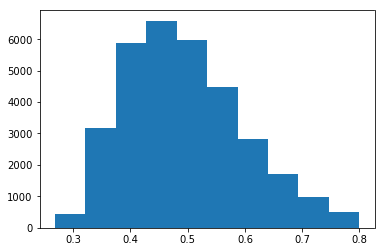

In [41]:
#Distribution of total volume fractions is roughly normally distributed:

plt.hist(total_volfrac_i)
print(np.percentile(total_volfrac_i,[2.5,97.5]))
print(np.average(total_volfrac_i),np.std(total_volfrac_i))

In [38]:
print(calcVoxelParams(63574,397969,654,2.94,0.5))

(0.0676990320106537, [0.3900462614752843, 0.11645189432814436, 0.08817339033720158, 0.5946715461406303], [13, 42, 418])


In [12]:
#Input variables
cell_mass = 159 #640
cell_vol = 1.5 #2.6
rib_num = 6800 #62000
tern_num = 57000 #383000

#Calculation of parameters. All units are femtograms or femtoliters (µm^3)
rib_mass= kD_to_fg(2300)
tern_mass = kD_to_fg(69)
rib_rad = 0.01305
tern_rad = 0.0059
crowder_rad = 0.0025
protein_density = 1.41 #g/cm^3
crowder_mass = ((4/3)*np.pi*(crowder_rad**3))*10**-12*protein_density*10**15 #~56kD
#crowder_rad = 0.0022
#crowder_mass = 3.819*10**-5
nucleoid_volfrac = 0.5

rib = Macromolecule(rib_mass, rib_rad,rib_num)
tern= Macromolecule(tern_mass,tern_rad, tern_num)
crowder = Macromolecule(crowder_mass,crowder_rad)
highCell = Cell(cell_mass,cell_vol,rib,tern,crowder, nucleoid_volfrac)
vox = Voxel(42, highCell)

In [13]:
rib.printProperties()
tern.printProperties()
highCell.printProperties()
crowder.printProperties()
vox.printProperties()


Number:  6800 
 Mass:  0.003819242 
 Radius:  0.01305 
 Vol:  9.309366842250778e-06 
 Total mass:  25.9708456 
 Total volume:  0.06330369452730529 
 Short time diffusivity:  25.20461423166669

Number:  57000 
 Mass:  0.00011457725999999999 
 Radius:  0.0059 
 Vol:  8.60289543468824e-07 
 Total mass:  6.530903819999999 
 Total volume:  0.04903650397772297 
 Short time diffusivity:  55.74918910563566

Mass:  159 
 Volume:  1.5 
 Rib vol frac:  0.08440492603640705 
 Tern vol frac: 0.032691002651815314 
 Crowder vol frac:  0.05981004755555556 
 Total vol frac: 0.1769059762437779

Number:  1370745.3189640318 
 Mass:  9.228428419920018e-05 
 Radius:  0.0025 
 Vol:  6.544984694978737e-08 
 Total mass:  126.49825058000002 
 Total volume:  0.08971507133333334 
 Short time diffusivity:  131.5680862893001

 Volume:  0.0011052631578947368 
 Voxel length:  0.10339238763784053 
 Rib vol frac:  0.08422760476322133 
 Tern vol frac: 0.032691002651815314 
 Crowder vol frac:  0.05980869347459142 
 Total


 Volume:  0.00031801566579634465 
 Voxel length:  0.0682573627945307 
 Rib vol frac:  0.40982614949218943 
 Tern vol frac: 0.11361755005122744 
 Crowder vol frac:  0.08685054977919814 
 Total vol frac: 0.610294249322615 
 Voxel num tern:  42 
 Voxel num rib:  14 
 Voxel num crowder:  422


In [42]:
# calcVoxelParams(7000,57000,258,1.44,0.5)

In [43]:
cell_mass = 258
cell_vol = 1.44
rib_num = 1000
tern_num = 57000
rib = Macromolecule(rib_mass, rib_rad,rib_num)
tern= Macromolecule(tern_mass,tern_rad, tern_num)
crowder = Macromolecule(crowder_mass,crowder_rad)
highCell = Cell(cell_mass,cell_vol,rib,tern,crowder, nucleoid_volfrac)
vox = Voxel(42, highCell)
vox.printProperties()


 Volume:  0.0010610526315789474 
 Voxel length:  0.1019950219145195 
 Rib vol frac:  0.008773708829502222 
 Tern vol frac: 0.034053127762307615 
 Crowder vol frac:  0.12194903774676898 
 Total vol frac: 0.16477587433857882 
 Voxel num tern:  42 
 Voxel num rib:  1 
 Voxel num crowder:  1977


In [ ]:
# Binding and unbinding/geminate reactions already accounted for in kinetic constant measurement itself?

In [ ]:
###For actual simulations, if there are 13 ribosomes and only 42 TRNA, I would expect that
#While tRNA are being checked by ribosome, more tRNA would diffuse in from the nucleoid
#Since ribosomes are only being represented as in the periphery...so maybe have a 
#rate for the appearance (0th order) of new tRNA? And then calculate translation rate as 
#time it takes half ribosomes to get correct tRNA. Or have to think of something else...?
#Maybe appear as a function of tRNA in the voxel. Calculate transport time as time the correct ternary complex
#is not bound to the correct ribosome? (that's technically reaction, but it's reaction on a different
#ribosome)?***Need to figure this out/ask drew/roseanna.

/Users/Akshay/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


mean:  3.2340798549248717 median:  3.0


Text(0.5, 0, 'Protein radius (nm)')

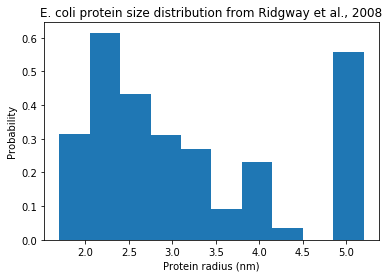

In [167]:
# Protein size distribution from Ridgway 2008:
num_proteins=[3697719,7242955,5105609,3674137,3162538,1068329,1133660,1350224,223451,419764,6561543,789551]
radius=[1.7,2.3,2.7,3,3.4,3.5,3.8,4,4.1,4.3,5.2,10.4]
mass = [11.4,29.1,46,67.2,91.4,107.1,132.8,156.1,161.7,186.5,346,2700]
proteindistrib =[]
for i in range(len(num_proteins)-1):
    proteindistrib.append([radius[i]]*num_proteins[i])
proteindistrib = [j for i in proteindistrib for j in i]
plt.hist(proteindistrib,bins=10,normed=True)
print("mean: ",np.mean(proteindistrib), "median: ", np.median(proteindistrib))
plt.title("E. coli protein size distribution from Ridgway et al., 2008")
plt.ylabel("Probability")
plt.xlabel("Protein radius (nm)")

mean:  3.2340798549248717 median:  3.0


Text(0.5, 0, 'Protein radius (nm)')

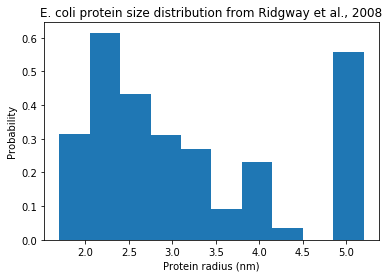

In [200]:
# Protein size distribution from Ridgway 2008:
num_proteins=[3697719,7242955,5105609,3674137,3162538,1068329,1133660,1350224,223451,419764,6561543,789551]
radius=[1.7,2.3,2.7,3,3.4,3.5,3.8,4,4.1,4.3,5.2,10.4]
mass = [11.4,29.1,46,67.2,91.4,107.1,132.8,156.1,161.7,186.5,346,2700]
proteindistrib =[]
for i in range(len(num_proteins)-1):
    proteindistrib.append([radius[i]]*num_proteins[i])
proteindistrib = [j for i in proteindistrib for j in i]
plt.hist(proteindistrib,bins=10,normed=True)
print("mean: ",np.mean(proteindistrib), "median: ", np.median(proteindistrib))
plt.title("E. coli protein size distribution from Ridgway et al., 2008")
plt.ylabel("Probability")
plt.xlabel("Protein radius (nm)")

In [28]:
(1.41 + 0.145*np.exp(-200*0.11/13))

1.436693659094729

In [29]:
(1.41 + 0.145*np.exp(-239*0.11/13))

1.4291907050553416

In [115]:
4/3*3.14159265*0.0025**3

6.544984687500001e-08

In [142]:
from scipy.optimize import minimize_scalar
import math
def func(m):
    return (1.41+0.145*math.exp(-m/(13)))-(m/(6.022*10**20))/(6.544*10**-8*10**-12)

res = minimize_scalar(func)
print(res.x)
print(res.fun)


nan
nan


In [ ]:
### Choosing server size benchmarking ####
import pandas as pd

#Sim time: 1ms (0.5*10^-8 µm^2/s timestep)
#Local macbook pro: 89, 87, 87, 88  seconds (expt_0)
#c4.large: 98 sec. (180904_0904)
#t3.small: 109 sec. (180904_0933)
#c5.large: 82 sec. (180904_0944)
#c5.18xlarge: 79 sec. (180904_0952)
#c5d.large: 82 (180904_1000)
#t3.micro: 107 sec. (180904_1007)
#t3.nano: 107 sec. (180904_1015)

data="180904_1015"
path = "/Users/Akshay/Dropbox/Life/EndyLab/Research/TranslationDynamics/data/"+data+"/"
df_outputs = pd.read_csv(path+"outputSimtimeList.txt",sep=" ",header=None)
sim_time = list()
for i, row in df_outputs.iterrows():
    df = pd.read_csv(path+row[0],delimiter=" ",header=None)
    df.columns=["simtime","runtime"]
    sim_time.append(int(df["runtime"]))

print(np.average(sim_time))

In [58]:
m=0.110*239
(1.41+0.145*math.exp(-m/(13)))

1.4291907050553416

In [97]:
m=0.11*200
(1.41+0.145*math.exp(-m/(13)))

1.436693659094729

In [100]:
m=40
(m/(6.022*10**20))/(((4/3)*(3.1415926)*(0.0025**3))*10**-12)

1.0148704614713686

In [126]:
m=55
(1.41+0.145*math.exp(-m/(13)))

1.4121084741023957

In [127]:
(m/(6.022*10**20))/(6.544*10**-8*10**-12)

1.3956568377237824

In [144]:
m=55.642
(1.41+0.145*math.exp(-m/(13)))-(m/(6.022*10**20))/(6.544*10**-8*10**-12)

5.8917871596175786e-05

In [ ]:
m=55.642
(1.41+0.145*math.exp(-m/(13)))-(m/(6.022*10**20))/(6.544*10**-8*10**-12)

In [147]:
(((6.544*10**-8*10**-12)*1.41)*6.022e+20)/0.11

505.13849890909086

In [178]:
(((11.3*10**-8*10**-12)*1.41)*6.022e+20)/0.11

872.2593272727272

In [222]:
r = 0.002
V = 4/3*3.14159265*r**3
aa = (((V*10**-12)*1.41)*6.022e+20)/0.11
m = aa*0.11

print("r: ", r)
print("Volume: ", V)
print("Num aa:", aa)
print("Mass: ", m, "KD")

r:  0.002
Volume:  3.35103216e-08
Num aa: 258.6698281018472
Mass:  28.453681091203194 KD


In [211]:
m = 33
aa = m/0.11
V = ((m/(6.022e20))/1.41)*1e12
r = ((3/4)*(1/3.1415)*V)**(1/3)

print("r: ", r)
print("Volume: ", V)
print("Num aa:", aa)
print("Mass: ", m, "KD")

r:  0.0021013227307576424
Volume:  3.8864588706657153e-08
Num aa: 300.0
Mass:  33 KD


In [181]:

(((11.3*10**-8*10**-12)*1.41)*6.022e+20)/0.11

872.2593272727272

In [161]:
30/0.11

272.72727272727275

In [183]:
4/3*3.14159265*0.003*3

0.0376991118

In [221]:
(4/3)*3.14159265*0.002**3

3.35103216e-08

In [220]:
trna_r = 0.0059
rib_r = 0.013
crowder_r = 0.0025
side_diameter = 0.0677

volfrac_desired = 0.116
print(volfrac_desired,volfrac_desired*(side_diameter**3)/(4/3*3.14159265*trna_r**3))
volfrac_desired = 0.43
print(volfrac_desired,volfrac_desired*(side_diameter**3)/(4/3*3.14159265*trna_r**3))



0.116 41.838812690896
0.43 155.09215049211446


In [ ]:
Do w/ 42 tRNA (phi = 0.116), and 144 tRNA (phi=0.4)